In [58]:
# dependencies
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm, trange

In [59]:
# period to predict
start_date = '2020-01-12'
end_date = '2020-01-19'

In [60]:
# data direct to dataframe
yf.pdr_override()
df = pdr.get_data_yahoo('EURUSD=X', start=start_date, end=end_date, interval='60m')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-01-13 00:00:00+00:00,1.111976,1.112471,1.111976,1.112100,1.112100,0
2020-01-13 01:00:00+00:00,1.112223,1.112718,1.112100,1.112471,1.112471,0
2020-01-13 02:00:00+00:00,1.112842,1.112966,1.112347,1.112842,1.112842,0
2020-01-13 03:00:00+00:00,1.112842,1.113462,1.112842,1.113462,1.113462,0
2020-01-13 04:00:00+00:00,1.113214,1.113710,1.113090,1.113214,1.113214,0
...,...,...,...,...,...,...
2020-01-17 18:00:00+00:00,1.109385,1.110001,1.109385,1.109632,1.109632,0
2020-01-17 19:00:00+00:00,1.109632,1.110001,1.109385,1.109878,1.109878,0
2020-01-17 20:00:00+00:00,1.109632,1.110001,1.109509,1.109509,1.109509,0


In [61]:
# derive candlestick components from ohlc
#  upper-shadow, lower-shadow, real-body
with tqdm(total=df.shape[0]) as pbar:
    
    for index, row in df.iterrows():
        pbar.update(1)

        # real body - positive=rising / negative=falling
        df.loc[index,'real_body'] = df.loc[index,'Close'] - df.loc[index,'Open']

        # rising candle
        if df.loc[index,'Close'] >= df.loc[index,'Open']: 
            df.loc[index,'upper_shadow'] = df.loc[index,'High'] - df.loc[index,'Close']
            df.loc[index,'lower_shadow'] = df.loc[index,'Open'] - df.loc[index,'Low']

        # falling candle   
        else:
            df.loc[index,'upper_shadow'] = df.loc[index,'Open'] - df.loc[index,'High']
            df.loc[index,'lower_shadow'] = df.loc[index,'Low'] - df.loc[index,'Close']  
        
# tidy up
df = df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close'})
df['date'] = df.index
df = df[['date', 'open', 'high', 'low', 'close', 'upper_shadow', 'lower_shadow', 'real_body']]
df

100%|██████████| 119/119 [00:00<00:00, 904.04it/s]


,date,open,high,low,close,upper_shadow,lower_shadow,real_body
Datetime,,,,,,,,
2020-01-13 00:00:00+00:00,2020-01-13 00:00:00+00:00,1.111976,1.112471,1.111976,1.112100,0.000371,0.000000,0.000124
2020-01-13 01:00:00+00:00,2020-01-13 01:00:00+00:00,1.112223,1.112718,1.112100,1.112471,0.000247,0.000124,0.000247
2020-01-13 02:00:00+00:00,2020-01-13 02:00:00+00:00,1.112842,1.112966,1.112347,1.112842,0.000124,0.000495,0.000000
2020-01-13 03:00:00+00:00,2020-01-13 03:00:00+00:00,1.112842,1.113462,1.112842,1.113462,0.000000,0.000000,0.000620
2020-01-13 04:00:00+00:00,2020-01-13 04:00:00+00:00,1.113214,1.113710,1.113090,1.113214,0.000496,0.000124,0.000000
...,...,...,...,...,...,...,...,...
2020-01-17 18:00:00+00:00,2020-01-17 18:00:00+00:00,1.109385,1.110001,1.109385,1.109632,0.000369,0.000000,0.000246
2020-01-17 19:00:00+00:00,2020-01-17 19:00:00+00:00,1.109632,1.110001,1.109385,1.109878,0.000123,0.000246,0.000246
2020-01-17 20:00:00+00:00,2020-01-17 20:00:00+00:00,1.109632,1.110001,1.109509,1.109509,-0.000369,0.000000,-0.000123


In [62]:
# gramian angular matrices (gam):
#  https://jfin-swufe.springeropen.com/articles/10.1186/s40854-020-00187-0
#  https://www.aaai.org/ocs/index.php/WS/AAAIW15/paper/viewFile/10179/10251 
#  https://github.com/pecu/Series2GAF/blob/master/cnn_example/series2gaf.py

# features
feature_list = ['close', 'real_body']

# image size => window_size(rows) x window_size(cols)
window_size = 10

# intialise the gam field
gramian_field = []

# number of data points
n = len(df['close'])

# loop through each feature
for this_feature in feature_list:

    # initialise the gam field for the feature
    gam_feature_set = []

    # loop through the data
    for i_data in trange(window_size, n+1, desc="Generating...", ascii=True):

        # select the data points to convert frm timeseries to gam (image)
        full_window_data =  list(df[this_feature][i_data-window_size : i_data])

        # scale the data
        rescaled_ts = np.zeros((window_size, window_size), float)
        min_ts = np.min(full_window_data)
        max_ts = np.max(full_window_data)
        diff = max_ts - min_ts
        if diff != 0:
            rescaled_ts = (full_window_data - min_ts) / diff

        # initialise the image
        this_gam = np.zeros((window_size, window_size), float)

        # calculate a component of the gam
        sin_ts = np.sqrt(np.clip(1 - rescaled_ts**2, 0, 1))

        # calculate the gam - summation method
        this_gam = np.outer(rescaled_ts, rescaled_ts) - np.outer(sin_ts, sin_ts)

        # add the gam to the feature set
        gam_feature_set.append(this_gam)

        # clear the gam ready for next
        del this_gam

    # ass the gam field of the feature set to the dataset
    gramian_field.append(gam_feature_set)

    # clear the gam field of the feature set
    del gam_feature_set

# finalise the gam field for each dataset
gam_pred = np.array(gramian_field)
gam_pred = np.moveaxis(gam_pred, 0, 3)
    
# summarise the results
print(f'| gam_pred: {gam_pred.shape} |')

Generating...: 100%|##########| 110/110 [00:00<00:00, 4349.01it/s]

| gam_pred: (110, 10, 10, 2) |


In [63]:
# load the model
model = load_model('./analysis/eurusd_hour_real_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [64]:
# predicted codes
predicted_codes = model.predict_classes(gam_pred)

#
#  TODO: how to extract labels (not codes) from model summary?
#        currently using hard-coded list of labels
#

# labels - in same order as model was trained
labels = ['negative', 'neutral', 'positive']
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# review the count of predicted categories
predicted_labels = label_encoder.inverse_transform(predicted_codes)
(unique, counts) = np.unique(predicted_labels, return_counts=True)
np.asarray((unique, counts)).T

array([['negative', '23'],
       ['neutral', '62'],
       ['positive', '25']], dtype='<U21')

In [65]:
# insert predictions in dataframe

# initialise new column
df['prediction'] = ''

# find column location for use with iloc
pred_colno = df.columns.get_loc('prediction')

# loop through the dataframe
with tqdm(total=df.shape[0]) as pbar:    
    for index, (_, row) in enumerate(df.iterrows()):
        pbar.update(1)
        
        # first prediction starts after the first 'window_size' samples
        if index >= window_size-1:
            df.iloc[index, pred_colno] = predicted_labels[index-window_size+1]

100%|██████████| 119/119 [00:00<00:00, 3802.29it/s]


In [66]:
# visualise the results
#  overlay candlesticks with slope predictions

# candlesticks
fig = go.Figure(data=[go.Candlestick(
    x=df.loc[start_date : end_date].index.strftime("%Y-%m-%d %H:%m"),    
    open=df['open'].loc[start_date : end_date], 
    high=df['high'].loc[start_date : end_date], 
    low=df['low'].loc[start_date : end_date], 
    close=df['close'].loc[start_date : end_date],
)])

# find the rows ion df that correspond to positive or negative slopes
positive_indices = np.where(df['prediction'] == 'positive')
negative_indices = np.where(df['prediction'] == 'negative')
noprediction_indices = np.where(df['prediction'].iloc[:window_size])

# add vertical rectangles for positive slopes
for i in positive_indices[0]:
    fig.add_vrect(
        x0=df.iloc[i,0].strftime("%Y-%m-%d %H:%m"), x1=df.iloc[i-5,0].strftime("%Y-%m-%d %H:%m"),
        fillcolor="Lightgreen", opacity=0.5,
        layer="below", line_width=0,
    )

# add vertical rectangles for negative slopes
for i in negative_indices[0]:
    fig.add_vrect(
        x0=df.iloc[i,0].strftime("%Y-%m-%d %H:%m"), x1=df.iloc[i-5,0].strftime("%Y-%m-%d %H:%m"),
        fillcolor="Lightpink", opacity=0.5,
        layer="below", line_width=0,
    )
    
# add vertical rectangles for no prediction data points
for i in noprediction_indices[0]:
    fig.add_vrect(
        x0=df.iloc[i,0].strftime("%Y-%m-%d %H:%m"), x1=df.iloc[i-9,0].strftime("%Y-%m-%d %H:%m"),
        fillcolor="black", opacity=0.5,
        layer="below", line_width=0,
    )

# annotate and configure the plot
fig.update_layout(
    title='EURUSD',
    yaxis_title='price',
    xaxis_rangeslider_visible=False,
    autosize=True,
)

fig.show()

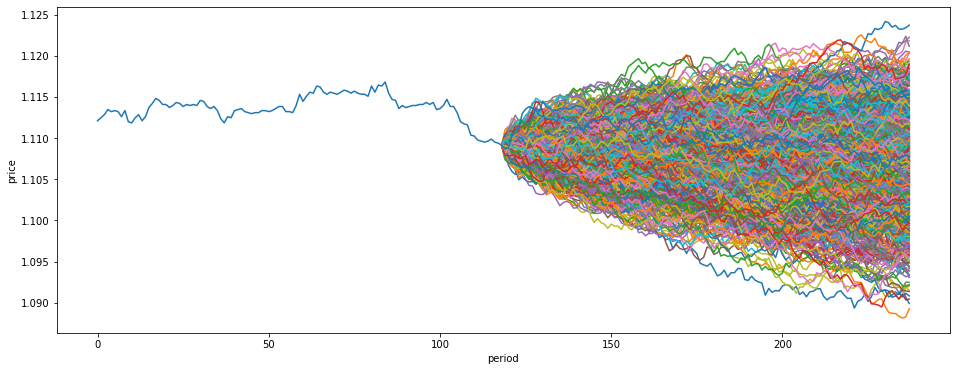

In [67]:
# monte carlo simulation of future prices

# seed value for the calculations
np.random.seed(42)

# number of periods to forecast
periods = df.shape[0]

# characterise the data - percentage change, mean, and sigma
df['daily_pc'] = df['close'].pct_change()
mu = df['daily_pc'].iloc[1:].mean()
sigma = df['daily_pc'].iloc[1:].std()

# simulate price - random walk
simulation = {}

# simulate from last real price data point
simulation['period'] = list(range(periods-1, periods+periods))

# create numerous simulated (forecast) timeseries
for i in range(1000):
    simulation['sim_'+str(i)] = [df['close'].iloc[-1]]
    for d in range(periods):
        simulation['sim_'+str(i)].append(
            simulation['sim_'+str(i)][-1]*
            np.exp((mu-(sigma**2/2))+sigma*np.random.normal())
        )

# new dataframe with real prices
real = {}
real['period'] = list(range(periods))
real['real'] = list(df['close'])
real = pd.DataFrame(real)

# simulation data frame with multiple price forecasts
simulation=pd.DataFrame(simulation)

# combine real and simulated dataframes
comb_df = real.merge(simulation, on='period', how='outer')
comb_df.drop(['period'], axis = 1, inplace = True)
comb_df.fillna(0.)

# plot combined dataframe
comb_df.plot(figsize=(16,6),grid=False,legend=False)
plt.xlabel('period')
plt.ylabel('price');

In [68]:
# visualise a 1D (closing price and real-body) timeseries 
#  as 2D images (Gramian angular matrix)

# animate all the predicted gams
fig = px.imshow(
    gam_pred,
    animation_frame = 0,  
    facet_col = 3,
    facet_col_wrap = 2,
    color_continuous_scale='blues'
) 

# include the frame number and predicted category in the title
fig.update_layout(
    title=f'GAM - {window_size-1} - {df["prediction"][window_size-1]}',
    autosize=True,
)
for k in range(len(fig.frames)):
    fig.frames[k]['layout'].update(title_text=f'GAF - {k} - {df["prediction"][k+window_size-1]}')

# change the facet labels to reflect the feature being displayed
for a in range(len(fig.layout.annotations)):
    fig.layout.annotations[a].text = feature_list[a]

fig.show()